<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-2CLS/blob/Only-Building/Kaggle_2CLS_Only_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arrow                            1.3.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
b

In [9]:
!pip uninstall jax -y

In [10]:
!pip install tensorflow==2.15.0

In [11]:
!python --version

Python 3.10.12


In [12]:
!pip install image_to_numpy==1.0.0

In [13]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [17]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [37]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=2, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=10,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [20]:
|def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [21]:
with tf.device('/gpu:0'):
    labels = ['Building', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [22]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [23]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [24]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [25]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [26]:
!mkdir MODEL

In [27]:
!ls ./

drive  MODEL  sample_data


In [39]:
model_name= 'Model 2CLS-OB-4.1.0'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-2Cls-Only-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/06fb8cb2-e139-4e70-b237-a26698d792b8
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 141.2449 - accuracy: 0.4500

105/105 [==============================] - ETA: 0s - loss: 18.7698 - accuracy: 0.7512
Epoch 1: val_loss improved from inf to 3.49063, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-0
105/105 [==============================] - 12s 64ms/step - loss: 18.7698 - accuracy: 0.7512 - val_loss: 3.4906 - val_accuracy: 0.5417 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 1.4688 - accuracy: 0.8310
Epoch 2: val_loss improved from 3.49063 to 0.95060, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-0
105/105 [==============================] - 6s 58ms/step - loss: 1.4688 - accuracy: 0.8310 - val_loss: 0.9506 - val_accuracy: 0.6500 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.8500
Epoch 3: val_loss improved from 0.95060 to 0.31507, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-0
105/105 [==============================] - 7s 63ms/step - loss: 0.8326 - accuracy: 0.8500 - val_loss: 0.

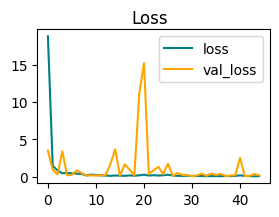

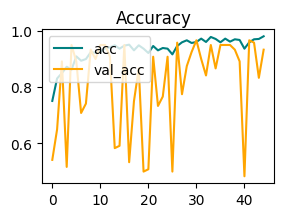

Fold Training Time: 0 hour(s) and 2 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-B: 96.72130584716797
F1Score-R: 96.61016845703125
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/d29dd8e1-dd8e-41a4-a0b4-bf1e268090ec
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 74.7171 - accuracy: 0.5500

105/105 [==============================] - ETA: 0s - loss: 14.0825 - accuracy: 0.7786
Epoch 1: val_loss improved from inf to 11.17965, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-1
105/105 [==============================] - 9s 59ms/step - loss: 14.0825 - accuracy: 0.7786 - val_loss: 11.1797 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 1.3527 - accuracy: 0.8488
Epoch 2: val_loss improved from 11.17965 to 0.67118, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-1
105/105 [==============================] - 7s 63ms/step - loss: 1.3527 - accuracy: 0.8488 - val_loss: 0.6712 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.8714
Epoch 3: val_loss did not improve from 0.67118
105/105 [==============================] - 3s 28ms/step - loss: 0.6658 - accuracy: 0.8714 - val_loss: 3.2979 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 4/45
105/105 [

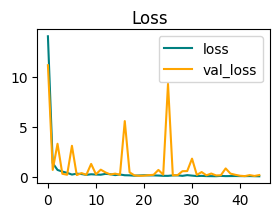

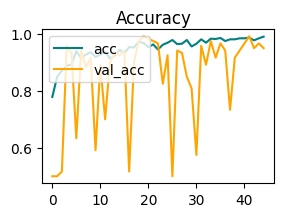

Fold Training Time: 0 hour(s) and 2 mins
Precision: 99.16666746139526  -  Recall: 99.16666746139526
Accuracy: 99.16666746139526
F1Score-B: 99.15966033935547
F1Score-R: 99.17355346679688
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/0c36c5e2-7c2c-4f9a-a287-374bc3252846
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 101.6618 - accuracy: 0.5500

105/105 [==============================] - ETA: 0s - loss: 17.3111 - accuracy: 0.8095
Epoch 1: val_loss improved from inf to 8.48729, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-2
105/105 [==============================] - 9s 58ms/step - loss: 17.3111 - accuracy: 0.8095 - val_loss: 8.4873 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 2.4160 - accuracy: 0.8679
Epoch 2: val_loss improved from 8.48729 to 3.14713, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-2
105/105 [==============================] - 7s 64ms/step - loss: 2.4160 - accuracy: 0.8679 - val_loss: 3.1471 - val_accuracy: 0.5333 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.9220 - accuracy: 0.8738
Epoch 3: val_loss improved from 3.14713 to 0.52447, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-2
105/105 [==============================] - 7s 64ms/step - loss: 0.9220 - accuracy: 0.8738 - val_loss: 0.5

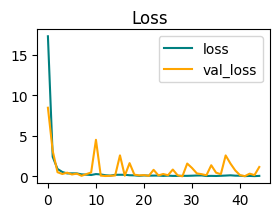

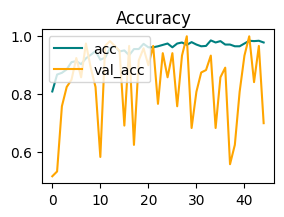

Fold Training Time: 0 hour(s) and 2 mins
Precision: 100.0  -  Recall: 100.0
Accuracy: 100.0
F1Score-B: 100.0
F1Score-R: 100.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/5db19239-aab9-45bc-9e47-fbfc4db67f1e
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 83.9021 - accuracy: 0.5250 

105/105 [==============================] - ETA: 0s - loss: 16.5293 - accuracy: 0.8083
Epoch 1: val_loss improved from inf to 12.29735, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-3
105/105 [==============================] - 9s 58ms/step - loss: 16.5293 - accuracy: 0.8083 - val_loss: 12.2973 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 2.5420 - accuracy: 0.8321
Epoch 2: val_loss improved from 12.29735 to 2.14402, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-3
105/105 [==============================] - 7s 64ms/step - loss: 2.5420 - accuracy: 0.8321 - val_loss: 2.1440 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 1.3918 - accuracy: 0.8560
Epoch 3: val_loss did not improve from 2.14402
105/105 [==============================] - 3s 28ms/step - loss: 1.3918 - accuracy: 0.8560 - val_loss: 4.9179 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 4/45
105/105 [

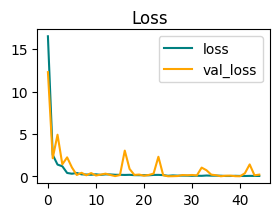

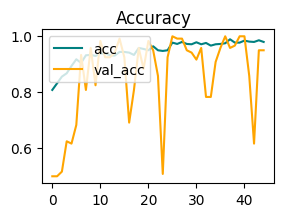

Fold Training Time: 0 hour(s) and 2 mins
Precision: 100.0  -  Recall: 100.0
Accuracy: 100.0
F1Score-B: 100.0
F1Score-R: 100.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/d5a26cac-fa78-41d3-ab6f-7108470ae473
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 89.1303 - accuracy: 0.6000 

105/105 [==============================] - ETA: 0s - loss: 14.7489 - accuracy: 0.7952
Epoch 1: val_loss improved from inf to 7.91429, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-4
105/105 [==============================] - 10s 64ms/step - loss: 14.7489 - accuracy: 0.7952 - val_loss: 7.9143 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.2030 - accuracy: 0.8452
Epoch 2: val_loss improved from 7.91429 to 0.48545, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-4
105/105 [==============================] - 7s 72ms/step - loss: 4.2030 - accuracy: 0.8452 - val_loss: 0.4854 - val_accuracy: 0.7917 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 1.4260 - accuracy: 0.8774
Epoch 3: val_loss did not improve from 0.48545
105/105 [==============================] - 3s 28ms/step - loss: 1.4260 - accuracy: 0.8774 - val_loss: 0.7235 - val_accuracy: 0.5917 - lr: 0.0020
Epoch 4/45
105/105 [==

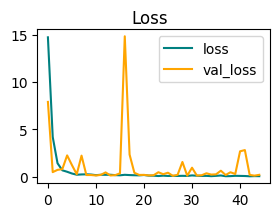

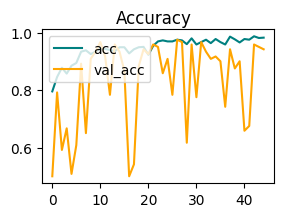

Fold Training Time: 0 hour(s) and 2 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.52066040039062
F1Score-R: 97.47898864746094
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/910b2d52-239f-4441-b414-195c36434946
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 77.1207 - accuracy: 0.6750

105/105 [==============================] - ETA: 0s - loss: 16.6229 - accuracy: 0.7798
Epoch 1: val_loss improved from inf to 8.38959, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-5
105/105 [==============================] - 9s 58ms/step - loss: 16.6229 - accuracy: 0.7798 - val_loss: 8.3896 - val_accuracy: 0.5083 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 3.4296 - accuracy: 0.8369
Epoch 2: val_loss improved from 8.38959 to 4.60677, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-5
105/105 [==============================] - 6s 59ms/step - loss: 3.4296 - accuracy: 0.8369 - val_loss: 4.6068 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.8247 - accuracy: 0.8726
Epoch 3: val_loss improved from 4.60677 to 2.57267, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-5
105/105 [==============================] - 7s 64ms/step - loss: 0.8247 - accuracy: 0.8726 - val_loss: 2.5

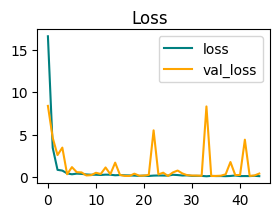

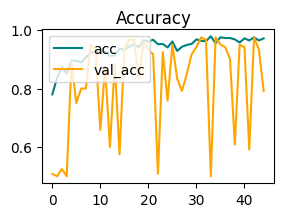

Fold Training Time: 0 hour(s) and 2 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.47898864746094
F1Score-R: 97.52066040039062
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/ffc62b05-2138-4a22-b707-0349e0663bb9
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 86.5381 - accuracy: 0.6250 

105/105 [==============================] - ETA: 0s - loss: 17.6317 - accuracy: 0.7643
Epoch 1: val_loss improved from inf to 1.54326, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-6
105/105 [==============================] - 9s 58ms/step - loss: 17.6317 - accuracy: 0.7643 - val_loss: 1.5433 - val_accuracy: 0.6083 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 2.3882 - accuracy: 0.8393
Epoch 2: val_loss did not improve from 1.54326
105/105 [==============================] - 3s 28ms/step - loss: 2.3882 - accuracy: 0.8393 - val_loss: 2.5471 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.8881
Epoch 3: val_loss did not improve from 1.54326
105/105 [==============================] - 3s 28ms/step - loss: 0.7587 - accuracy: 0.8881 - val_loss: 3.4578 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 4/45
105/105 [==============================] - ETA: 0s - loss: 0.6063 - accurac

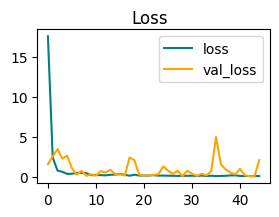

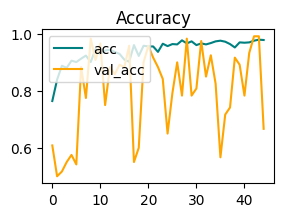

Fold Training Time: 0 hour(s) and 2 mins
Precision: 99.16666746139526  -  Recall: 99.16666746139526
Accuracy: 99.16666746139526
F1Score-B: 99.17355346679688
F1Score-R: 99.15966033935547
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/7ae397c1-f4d9-4521-a99e-c21f536cf783
Epoch 1/45
  5/105 [>.............................] - ETA: 2s - loss: 95.5609 - accuracy: 0.6250

105/105 [==============================] - ETA: 0s - loss: 18.7904 - accuracy: 0.7786
Epoch 1: val_loss improved from inf to 13.17037, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-7
105/105 [==============================] - 10s 64ms/step - loss: 18.7904 - accuracy: 0.7786 - val_loss: 13.1704 - val_accuracy: 0.5000 - lr: 0.0020
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 0.8994 - accuracy: 0.8833
Epoch 2: val_loss improved from 13.17037 to 11.06721, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-7
105/105 [==============================] - 6s 58ms/step - loss: 0.8994 - accuracy: 0.8833 - val_loss: 11.0672 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.8810
Epoch 3: val_loss improved from 11.06721 to 1.77109, saving model to /content/MODEL/Model 2CLS-OB-4.1.0/FOLD-7
105/105 [==============================] - 6s 59ms/step - loss: 0.9291 - accuracy: 0.8810 - val_lo

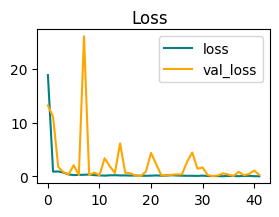

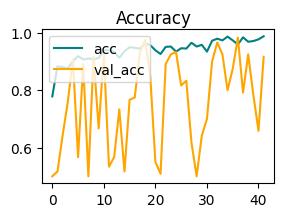

Fold Training Time: 0 hour(s) and 2 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.4358901977539
F1Score-R: 97.56097412109375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 22 mins


In [40]:
params = {
    "lr": 0.002,
    "epochs": 45,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_bld = []
f1_road = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_bld.append(f1_s[0])
        f1_road.append(f1_s[1])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-B"] = f1_bld[counter]
        run["eval/F1-R"] = f1_road[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-B: {f1_bld[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [41]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-B: {avg_rate(f1_bld)}
Avg F1-Score-R: {avg_rate(f1_road)}
""")


Avg Accuracy: 98.43750074505806
Avg Precision: 98.43750074505806
Avg Recall: 98.43750074505806
Avg F1-Score-B: 98.43625736236572
Avg F1-Score-R: 98.43800067901611



In [42]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-B"] = avg_rate(f1_bld)
run["eval/F1-R"] = avg_rate(f1_road)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/11832fc1-23b2-4402-9be3-422d40c71906
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [43]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [44]:
!neptune sync -p 'New-Thesis/Kaggle-2Cls-Only-Building' --offline-only


Offline container 9bd755aa-5960-4505-a1c7-c0e72a7699b2 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-10
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-10
Deleted: /content/.neptune/async/run__9bd755aa-5960-4505-a1c7-c0e72a7699b2__57820__feitq5ic
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-10 completed.
Offline container 9bd755c2-c5ab-4b58-9e1a-7ea3f0f7dd83 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-11
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-11
Deleted: /content/.neptune/async/run__9bd755c2-c5ab-4b58-9e1a-7ea3f0f7dd83__57820__h8hy5ksw
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-11 completed.
Offline container 9bd755c3-5681-45a3-a4c8-e9ab6727f028 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-12
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-12
Deleted: /content/.neptune/async/run__9bd755c3-5681-45a3-a4c8-e9ab6727f028__57820__o9meeh6i
Synchronization of run New-Thesis/Kaggle-2Cls-O

In [45]:
!neptune clear


In [36]:
!rm -r "/content/MODEL/Model 2CLS-OB-4.1.0"